# Integrate two Xenium samples using Python

**This vignette is part of [The Xenium In Situ Gene Expression Data Analysis Workshop](https://www.10xgenomics.com/analysis-guides/workshop-xenium-in-situ-analysis)**


How to use this Google Colab


- Select Python as the programming language: Click “Runtime”, then ensure “Runtime type” is set to “Python”. We recommend selecting “v5e-1 TPU” for this Google Colab tutorial. There could be TPU usage [limit](https://research.google.com/colaboratory/faq.html#usage-limits).
- Click the “Connect” button on the top-right corner. Now, you are ready to run the tutorial.
- You can run the analysis using the data we provided in the code. Alternatively, you can also load your own data.

*Note: If you have other colab sessions open, we recommend closing other sessions before starting this one to avoid interruption. To close other sessions, go to `Runtime` -> `Manage Sessions`*


# Install and import packages

In [ ]:
!uv pip install scanpy==1.11.2 spatialdata[extra]==0.4.0 scikit-misc==0.5.1 squidpy==1.6.5 harmonypy==0.0.10 geosketch==1.3 igraph==0.11.8
# import the python packages
import scanpy as sc
import spatialdata as sd
import pandas as pd
import numpy as np
import h5py
import anndata as ad
import spatialdata_io as sio
import spatialdata_plot
import matplotlib.pyplot as plt
import warnings
import os
import squidpy as sq
import pickle

warnings.filterwarnings("ignore")

# **3. Xenium Prime multi-sample integration using Harmony**

In this section, we are integrating the two Xenium datasets: Human breast cancer Xenium Prime data and Human cervical cancer Xenium Prime data on the same panel. The goal of the integration between the two datasets is to test the hypothesis that macrophages in these two cancer types play different roles.

*Note: The two Xenium datasets were generated using the same Xenium gene panel. The integration of Xenium data from different Xenium gene panels is not recommended, since gene probe sets and codewords differ between gene panels. We have more details on multiple samples integration in this KB: ["How do you integrate multiple samples for Xenium analysis?"](https://kb.10xgenomics.com/hc/en-us/articles/35468186410253-How-do-you-integrate-multiple-samples-for-Xenium-analysis)*



## 3.1 Downloading breast and cervical Xenium Prime data

Xenium data can be large. These two datasets have a total of more than 1.5 million cells. Currently, the on-disk (out-of-core) preprocessing pipeline for python is still experimental. Users who are interested in on-disk preprocessing can refer to [scanpy's dask tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/experimental/dask.html) on how to do on-disk preprocessing. However, many of scanpy's functions are still not currently supported in dask.

To manage memory in this section, we keep the main `matrix(adata.X)` sparse to be memory efficient.

Here we will need `cell_feature_matrix.h5` from both breast and cervical Xenium Prime outputs. This file can be found in Xenium output bundle.

* https://www.10xgenomics.com/datasets/xenium-prime-ffpe-human-breast-cancer
* https://www.10xgenomics.com/datasets/xenium-prime-ffpe-human-cervical-cancer

In [ ]:
# Download the data and unzip it
! wget https://cf.10xgenomics.com/supp/xenium/analysis-workshop/multi-sample-analysis.tar.gz
! tar -xzvf ./multi-sample-analysis.tar.gz

In [ ]:
# Read data into anndata
adata_breast = sc.read_10x_h5("./multi-sample-analysis/human_breast_xenium/cell_feature_matrix.h5")
adata_cervical = sc.read_10x_h5("./multi-sample-analysis/human_cervical_xenium/cell_feature_matrix.h5")

Since there are multiple samples in this demo, it's a good practice to make sure cell IDs are unique across all integrated samples. Here, we add a suffix to the cell IDs. For example, we add "_breast" suffix to each cell ID in breast cancer data and "_cervical" suffix to each cell ID in cervical cancer data.

In [ ]:
adata_breast.obs_names = adata_breast.obs_names + "_breast"
adata_cervical.obs_names = adata_cervical.obs_names + "_cervical"
adata_breast.obs['tissue'] = 'breast'
adata_cervical.obs['tissue'] = 'cervical'

## 3.2 Conventional data processing by processing in memory

For this section, we will first combine the breast and cervical Xenium datasets, followed by the same preprocessing done in Section 2.5.1.


In [ ]:
adata = ad.concat([adata_breast, adata_cervical])

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, inplace=True, log1p=True
)

The preprocessing follows the exact steps in Section 2.5.1. The first step is QC. We want to remove cells with low transcript counts. Here we plot the distribution of transcript counts per cell in a histogram to decide the lower cutoff in transcript counts (aiming to remove cells with low transcript counts). The determination of lower cutoff can be subjective. There is no gold-standard rule.

In [ ]:
fig = plt.hist(adata.obs['total_counts'], range=(0, 200), bins=100)
plt.axvline(x=20, color='red', linestyle='--')  # You can customize color and linestyle

In [ ]:
thres = np.quantile(adata.obs['total_counts'], 0.98)
sc.pp.filter_cells(adata, min_counts=20)
sc.pp.filter_cells(adata, max_counts=thres) # high transcript count cells, outlier

sc.pp.filter_genes(adata, min_cells = 100)

In [ ]:
# Again, we create a new layer in the adata.
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.highly_variable_genes(adata, flavor = "seurat_v3", n_top_genes = 2000, layer = "counts")

This step is needed before sketching the data, for live demo, we will skip it and directly use the processed sketch index

In [ ]:
## Normalization and Scale the data and PCA
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
# adata.layers["lognorm"] = adata.X.copy()
# sc.pp.scale(adata, zero_center=False, max_value = 10)
# sc.pp.pca(adata, n_comps=30)
## Use this function is you are using the dask function
## adata.obsm["X_pca"] = adata.obsm["X_pca"].compute()

## 3.3 Sketching of data for faster visualization

Sketching downsamples the data while aiming to retain rarer cell types. This sketched data is then used to generate a downsampled UMAP for a quicker visualization.

This approach is different from Seurat's sketch analysis in R, where the downstream analysis is performed directly on the sketched data. In our method, we use the whole dataset for the full analysis, although you can still choose to generate the UMAP on the original dataset.

In [ ]:
# # This step will take ~5 mins, we will skip it and just directly load the sketch_index for workshop demo
# import geosketch as gs
# N = 50000 # Number of cells to obtain from the data set.
# sketch_index = gs.gs(adata.obsm['X_pca'], N, replace=False)

# # Save the sketch_index to a pickle file
# import pickle
# with open('sketch_index.pkl', 'wb') as f:
#   pickle.dump(sketch_index, f)

The step above takes some time, so we have already generated the sketch index. It can be directly loaded as a pickle file during the workshop.

In [ ]:
## download the sketch index
!wget https://cf.10xgenomics.com/supp/xenium/analysis-workshop/sketch_index.pkl

In [ ]:
# import the sketch_index from the pickle file
import pickle
with open('sketch_index.pkl', 'rb') as f:
    sketch_index = pickle.load(f)

## 3.4 Batch correction with Harmony

Before doing batch correction, we can check if there are significant batch effects between these two data: project cells in 2D UMAP space without any batch correction and visualize cells by their sample origin. If most of cell types are very well separated between samples in UMAP space, it could indicate there are batch effects.

In [ ]:
# This step will take ~2 mins

# sketch the anndata object using sketch_index
adata_sketch = adata[sketch_index]

# computes the neighborhood graph of cells in the adata_sketch object
# pp: Stands for "pre-processing"
sc.pp.neighbors(adata_sketch, metric = "cosine")

# computes UMAP for the adata_sketch object, tl: Stands for "tools".
# the UMAP coordinates are stored in adata_sketch.obsm['X_umap'].
sc.tl.umap(adata_sketch)

Data exploration: Take a look at the differences between `adata` and `adata_sketch`.

In [ ]:
# Create a UMAP plot
sc.pl.umap(adata_sketch, color = 'tissue')

If there are significant batch effects, we can use Harmony to correct batch effects. In this demo, we continue doing batch correction using Harmony. Harmony will correct `PCA` space (which contains variations from batch effects). After removing batch effects, Harmony will generate new corrected reduced-dimension results. It is labeled as `X_pca_harmony` and accessed via `adata.obsm["X_pca_harmony"]`.

In [ ]:
# # This step will take ~5 mins, we will skip it and just directly load the post-Harmony adata object
# # Please note that Harmony is run on the original data and not the sketched data
# sc.external.pp.harmony_integrate(adata, key = "tissue")

In [ ]:
# Download the combined data after Harmony integration
!wget https://cf.10xgenomics.com/supp/xenium/analysis-workshop/breast_cervical_adata.h5ad

In [ ]:
# Load the combined data after Harmony integration
adata = sc.read_h5ad("./breast_cervical_adata.h5ad")

In [ ]:
# This step takes ~ 2 min

# Apply the pre-computed batch correction results to the sketched subset
adata_sketch_harmony = adata[sketch_index]

# Computes the neighborhood graph and UMAP
sc.pp.neighbors(adata_sketch_harmony, use_rep = "X_pca_harmony", metric = "cosine")
sc.tl.umap(adata_sketch_harmony)

While downloading and loading the processed data into the python environment, let's talk about how Harmony works for batch effect correction.




In [ ]:
sc.pl.umap(adata_sketch_harmony, color='tissue')

In [ ]:
# Let's plot them side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sc.pl.umap(adata_sketch, color = 'tissue', ax=axs[0], show=False, title="Before Harmony", legend_loc="none")
sc.pl.umap(adata_sketch_harmony, color='tissue', ax=axs[1], show=False, title="After Harmony")
plt.tight_layout()
plt.show()

In [ ]:
# # Skip for the demo purposes, this step is running leiden cluster after Harmony
# the processed data already has the leiden cluster after Harmony
# sc.pp.neighbors(adata, use_rep = "X_pca_harmony", metric = "cosine")
# sc.tl.leiden(adata, flavor = "igraph", n_iterations=-1, resolution = 1.2)

In [ ]:
# We use the labels in the full dataset for the smaller sketched adata
# Before Harmony
adata_sketch.obs["leiden"] = adata.obs["leiden"]
sc.pl.umap(adata_sketch, color = 'leiden')

In [ ]:
# After Harmony
sc.pl.umap(adata_sketch_harmony, color = 'leiden')

## 3.5 Export all cell clustering results in CSV and import to Xenium Explorer

After batch correction, we can export batch corrected clustering results in CSV files for both breast cancer and cervical cancer data separately. We can import each sample's clustering results (generated by integrated analysis) into its own Xenium Explorer window.

In [ ]:
clusters_breast = adata[adata.obs.tissue == "breast"].obs.copy()
clusters_breast.index = clusters_breast.index.str.replace('_breast', '')
clusters_breast['cell_id'] = clusters_breast.index.str.split("-").str[0] + "-" + clusters_breast.index.str.split("-").str[1]
clusters_breast['group'] = clusters_breast['leiden']
clusters_breast.loc[:, ["cell_id", "group"]].to_csv("clusters_breast.csv", index = False)

We can follow Session 2.5.4 to import `clustering_breast.csv` file into Xenium Explorer

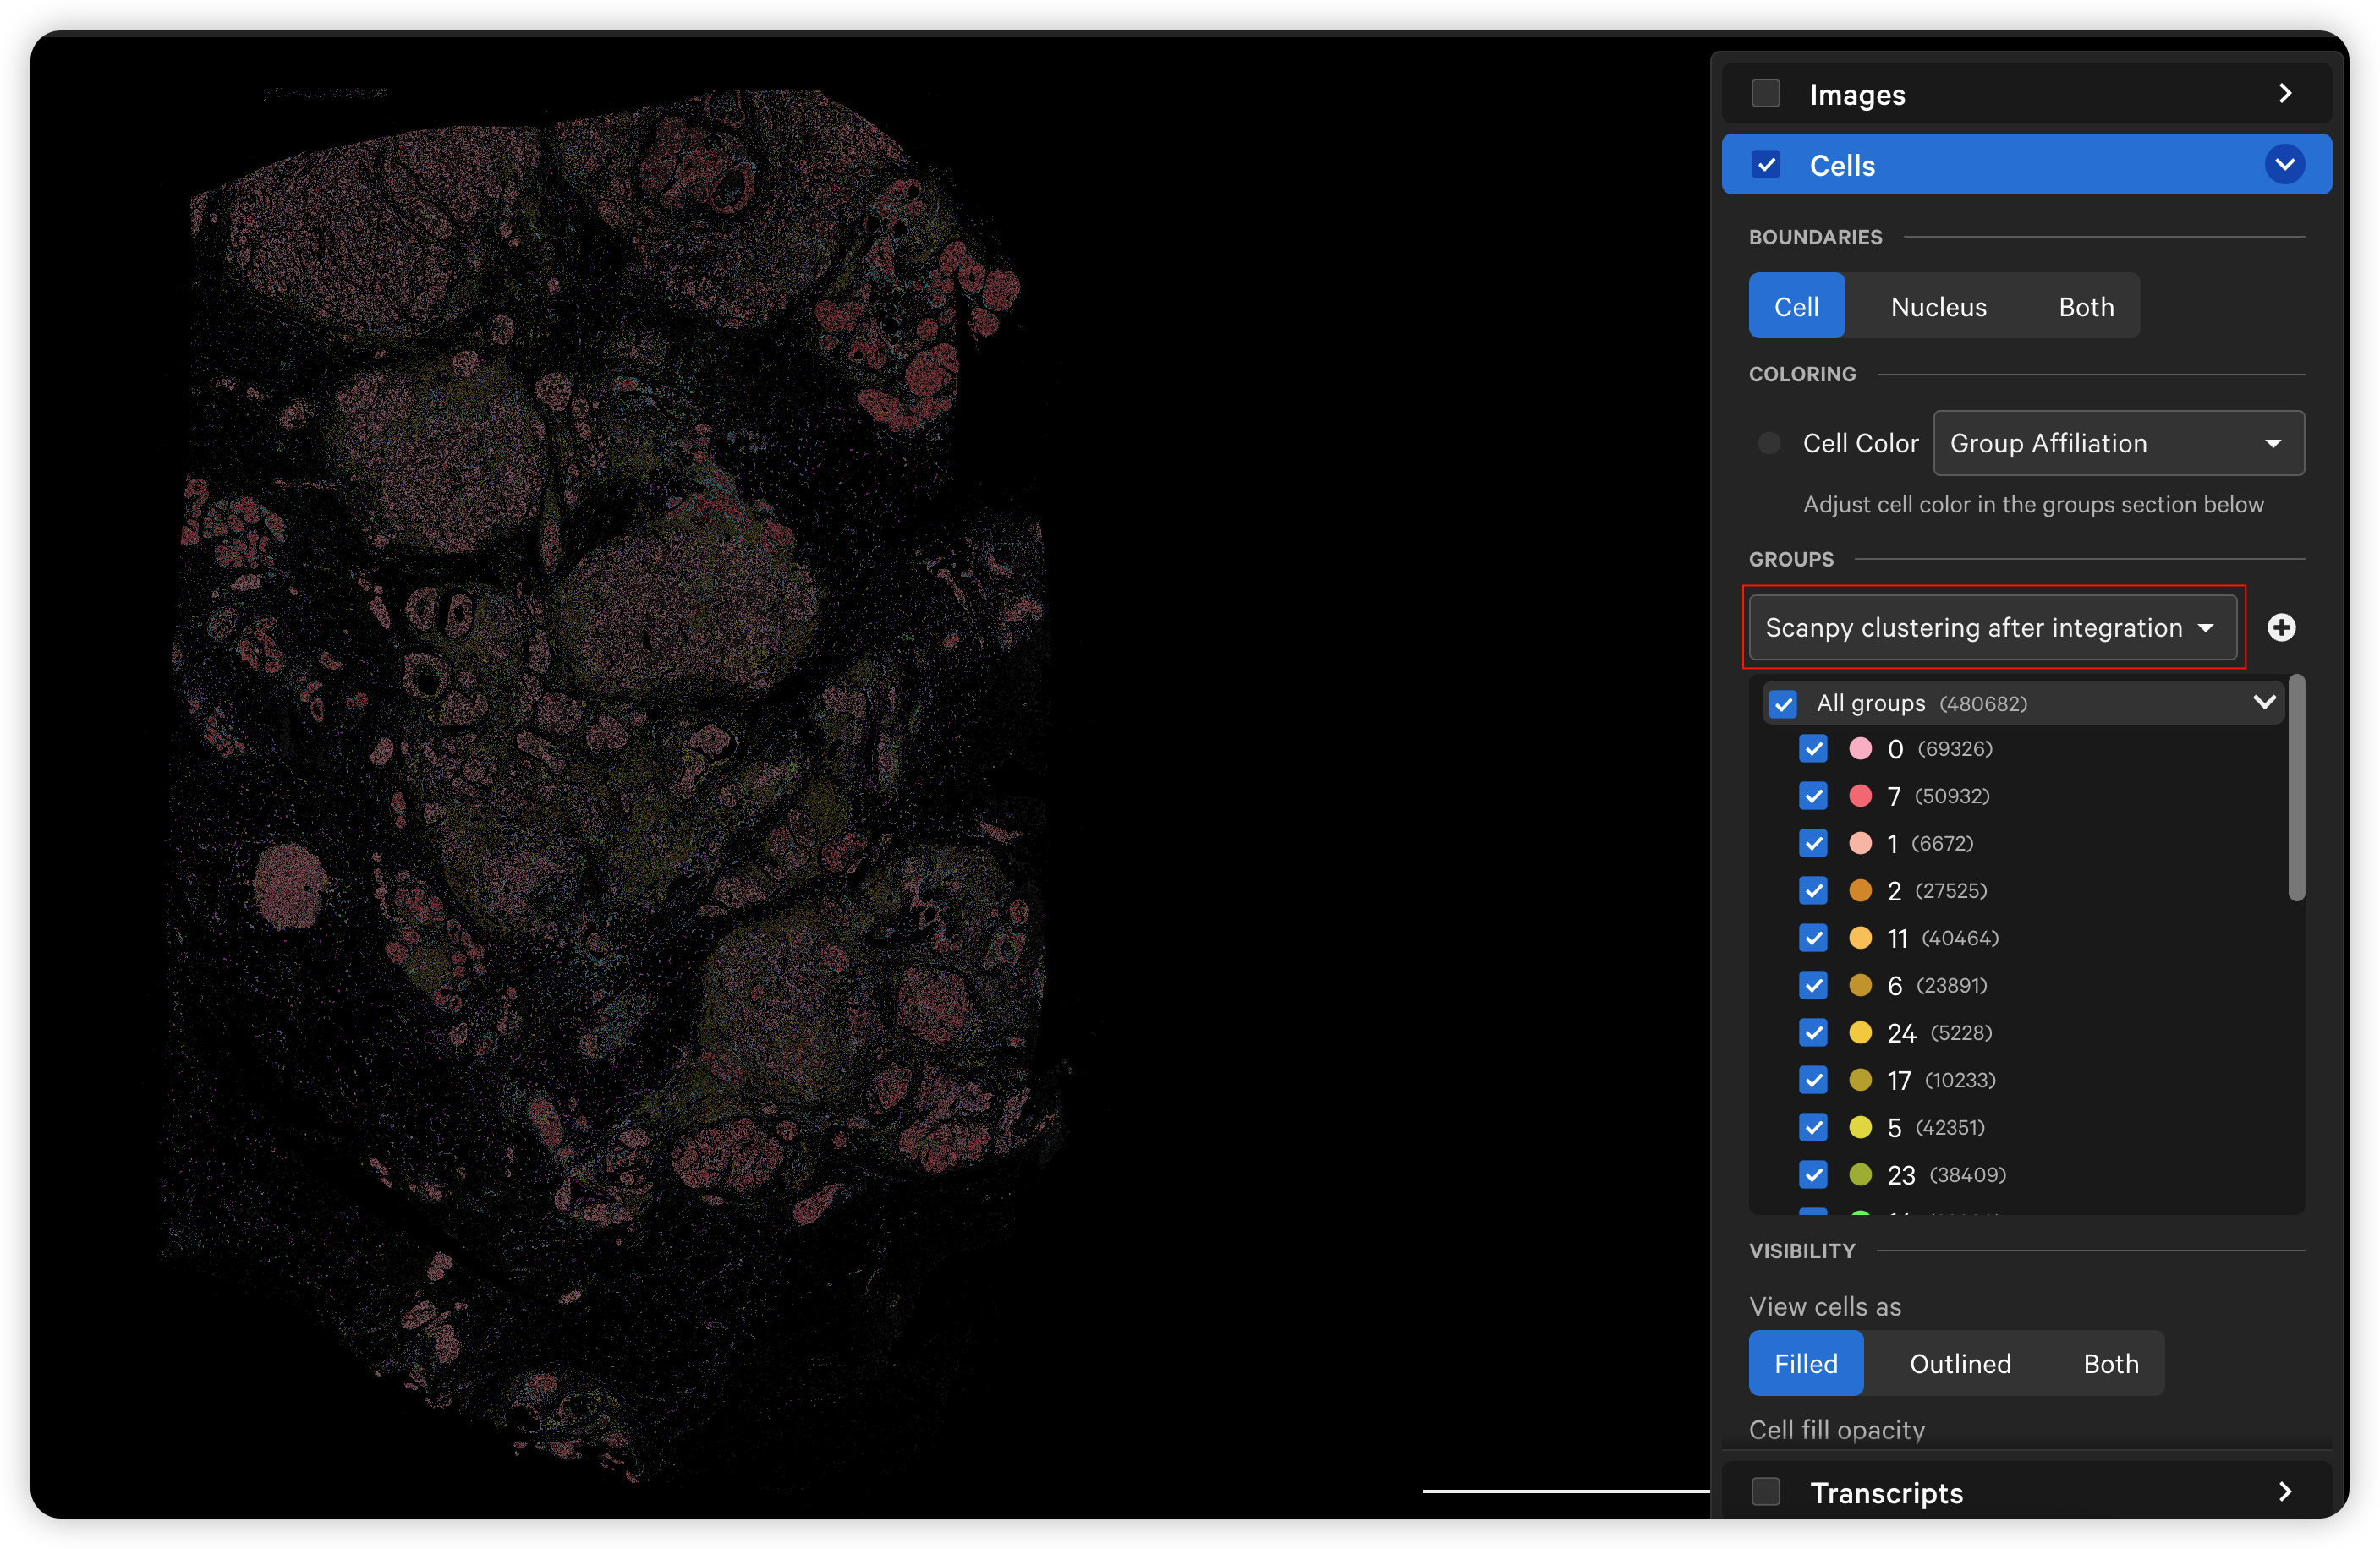

## 3.6 Find cluster marker genes for cell annotation



We can compute top differentially expressed genes in each cluster and accordingly annotate each cluster using these genes. To annotate the cell types, we can use tools like [Enrichr](https://maayanlab.cloud/Enrichr/), or an AI agent like Gemini.

In [ ]:
sc.settings.verbosity = 0 # suppress informational messages

# find marker genes for each cluster
sc.tl.rank_genes_groups(adata, groupby = "leiden", layer = "lognorm", pts = True)

# dotplot top 3 marker genes for each cluster
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 3)

# save the figure
plt.savefig("high_rank_genes_dotplot.png")

Based on the marker genes, we can identify that cluster 5 is highly enriched with macrophage marker genes (*C1QC*, *MS4A6A*, *CTSL*).

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, groups=["5"])

In [ ]:
# list the top ranked genes in group 5
ranked_genes_df = sc.get.rank_genes_groups_df(adata, group="5")
ranked_genes_df.head(10)

## 3.7 Subset for macrophages

Below, we subset the data for macrophages only and compare gene expression in macrophages between breast cancer and cervical cancer data. The demonstration below is for exploration purposes to compare macrophages between two tissue types. The p-values obtained from this analysis should be interpreted with caution, because these tests treat each bin as an independent replicate, which could cause false positives.

**A more robust statistic test for differential expression genes (DEG) between conditions requires biological replicates (at least 3 biological replicates per condition are recommended) and pseudo-bulk DEG analysis approach can be used for this analysis.** See more documentation below:

*   [Differential Gene Expression Analysis in scRNA-seq Data between Conditions with Biological Replicates](https://www.10xgenomics.com/analysis-guides/differential-gene-expression-analysis-in-scrna-seq-data-between-conditions-with-biological-replicates)
*   [Use PyDESeq2 for pseudo-bulk DE analysis](https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_step_by_step.html#sphx-glr-auto-examples-plot-step-by-step-py)


In [ ]:
# Subset the object to macrophages cluster
adata_macrophages = adata[adata.obs.leiden == "5"]

Re-do analyses: Find variable genes, data normalization and scaling, PCA, Harmony batch correction (on PCA), UMAP, and clustering on macrophage cells only.

In [ ]:
# This block will run ~ 5 mins
# adata_macrophages.X = adata_macrophages.layers["counts"].copy()
sc.pp.highly_variable_genes(adata_macrophages, n_top_genes = 2000, flavor = "seurat_v3")
sc.pp.normalize_total(adata_macrophages)
sc.pp.log1p(adata_macrophages)

adata_macrophages.layers["lognorm"] = adata_macrophages.X.copy()

sc.pp.scale(adata_macrophages, zero_center = False, max_value = 10)
sc.pp.pca(adata_macrophages, n_comps = 30)

sc.external.pp.harmony_integrate(adata_macrophages, key = "tissue")
sc.pp.neighbors(adata_macrophages, use_rep = "X_pca_harmony")
sc.tl.umap(adata_macrophages)

Compute DEG in macrophages between breast cancer and cervical cancer data.

In [ ]:
sc.tl.rank_genes_groups(adata_macrophages, groupby = "tissue", layer = "lognorm")
sc.pl.rank_genes_groups_dotplot(adata_macrophages)

Based on DEG results, mean expression level of _CTSL_ is higher in breast cancer macrophages compared to those in cervical cancer.

In [ ]:
sc.pl.violin(adata_macrophages, groupby = "tissue", keys = "CTSL", layer = "lognorm", size = 0.5)

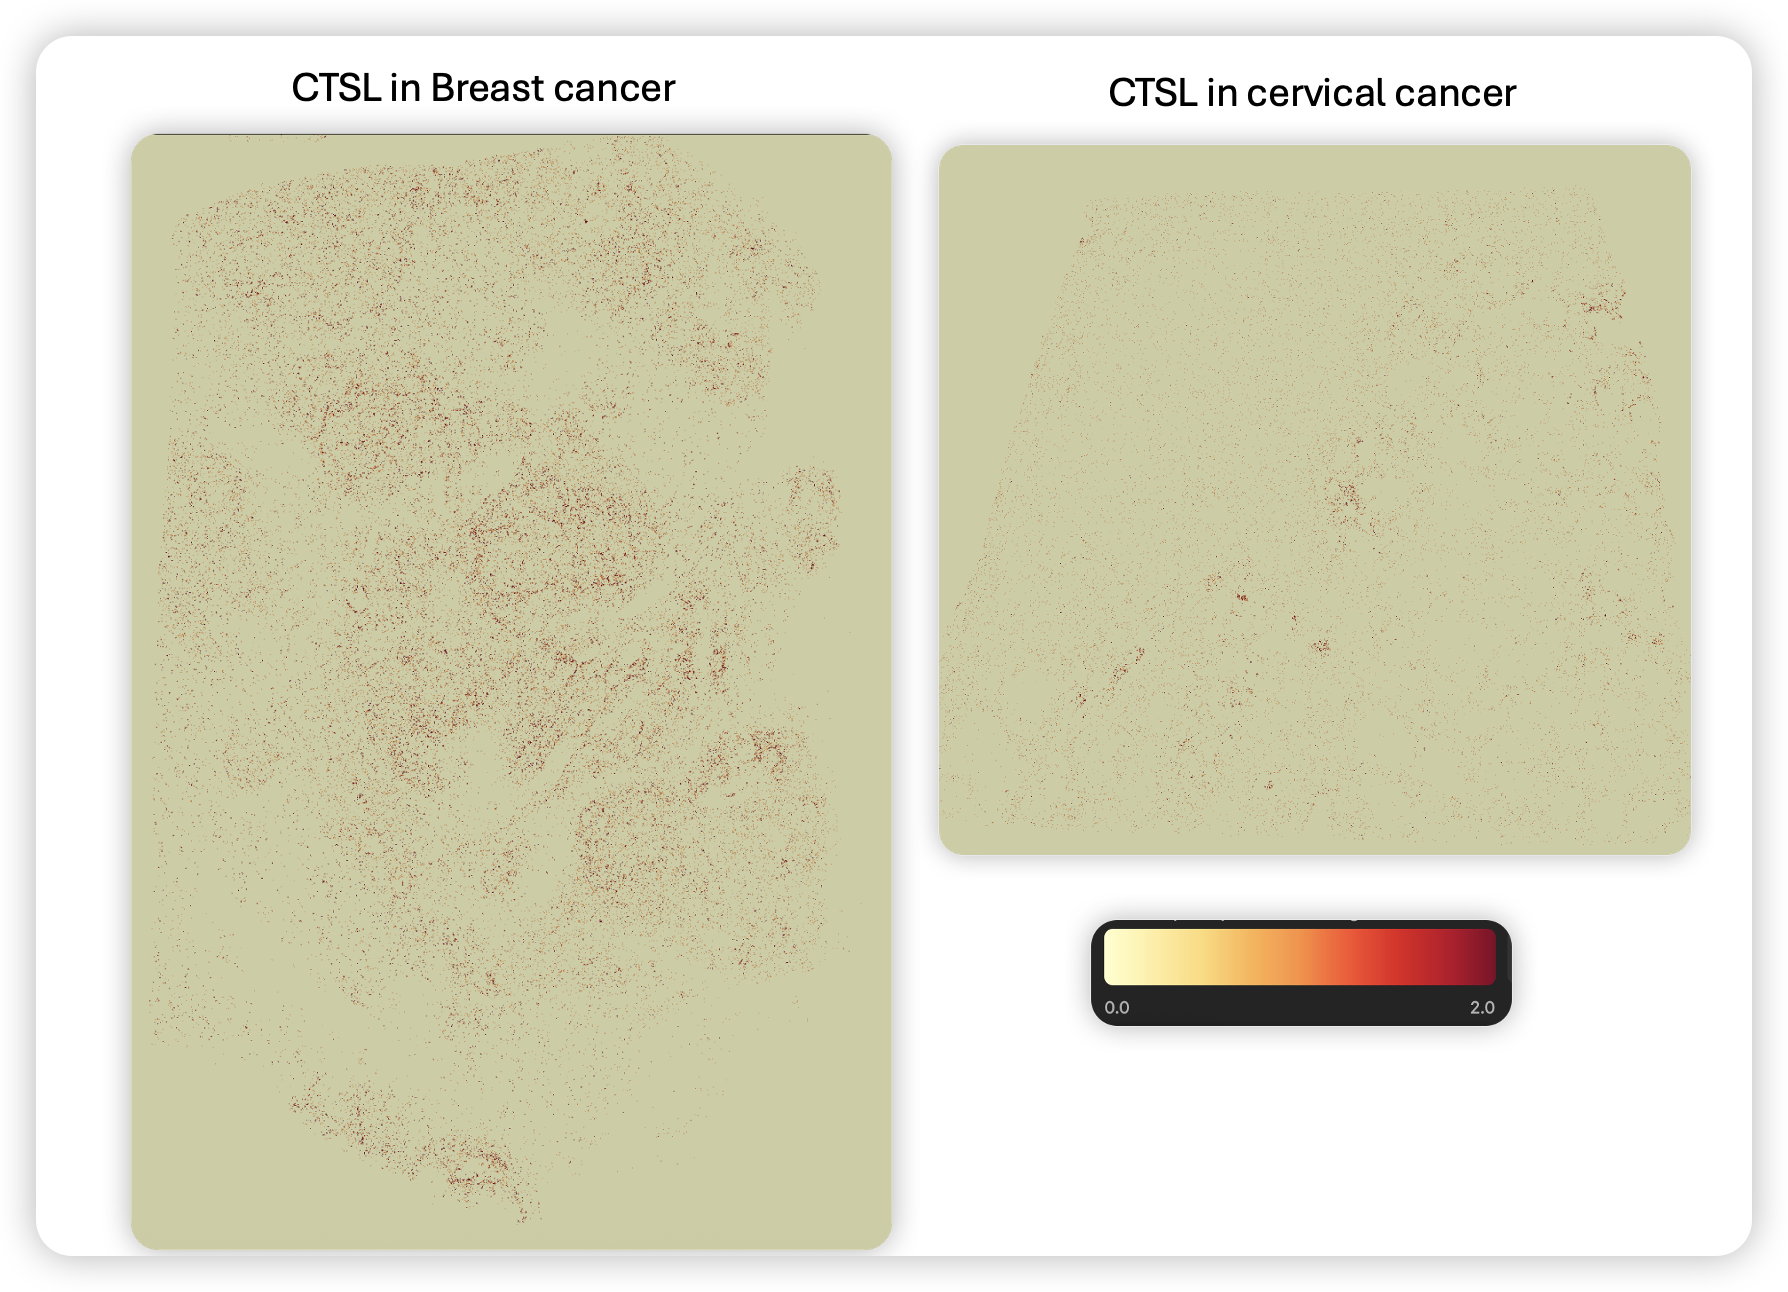

Higher expression of _CTSL_ in macrophages is reported to be associated with tumor progression and poor prognosis ([Zhang, et al., 2024](https://www.sciencedirect.com/science/article/pii/S2405844024053040), [Alderton, 2010](https://www.nature.com/articles/nrc2816), [Xiao, et al., 2024](https://www.wjgnet.com/1007-9327/full/v30/i47/5032.htm)). Our analysis of the tutorial data shows higher expression of _CTSL_ in breast cancer tissue macrophages, suggesting more of a pro-tumor role of macrophages in breast cancer compared to cervical cancer.